In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = '../data'
merge_file = 'pilot1'
plot_folder = '../plots/pilot1'

In [3]:
df = pd.read_csv(os.path.join(folder, f'{merge_file}_player_round.csv'))

<Figure size 1008x720 with 0 Axes>

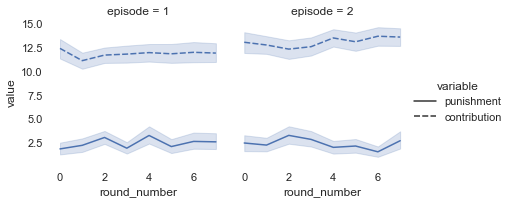

In [4]:
plt.figure(figsize=(14,10))

dfm = df.melt(
    id_vars=['global_group_id', 'round_number', 'participant_code', 'episode'], 
    value_vars=['punishment', 'contribution'])

dfm['episode'] = dfm['episode'].astype(str)

g = sns.relplot(
    data=dfm,
    x="round_number", y="value",
    col='episode',
    style='variable',
    kind="line",
    height=3, aspect=1,
)
plt.savefig(os.path.join(plot_folder, 'temporal.jpg'), dpi=300, transparent=False)